# Creative Gaming: Uplift Modeling

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyrsm as rsm
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 150


# checking pyrsm version
rsm.__version__  # should be 0.7.4 or higher

'0.7.5'

In [2]:
## setup pyrsm for autoreload when you edit code and save
## nothing else needed!
%reload_ext autoreload
%autoreload 2
%aimport pyrsm


1. Prepare the data (5 points): 

a. Add a variable “ad” to cg_ad_random and set its value to 1 for all rows \
b. Add a variable “ad” to cg_organic_control and set its value to 0 for all rows \
c. Create a stacked dataset for the uplift analysis by combining cg_organic_control (Group 1) and cg_ad_random (Group 2). Use cg_rct_stacked as the name for the stacked dataset. \\


In [3]:
## loading the data - this dataset must NOT be changed
cg_organic_control = pd.read_pickle("data/cg_organic_control.pkl")
cg_organic_control["ad"] = 0
rsm.describe(cg_organic_control)

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Uplift Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")


In [4]:
## loading the data - this dataset must NOT be changed
cg_ad_random = pd.read_pickle("data/cg_ad_random.pkl")
cg_ad_random["ad"] = 1
rsm.describe(cg_ad_random)

## Creative gaming

Game telemetry dataset used for the Creative Gaming: Uplift Modeling case

#### Feature descriptions

* converted: Purchased the Zalon campain ("yes" or "no")
* GameLevel: Highest level of game achieved by the user
* NumGameDays: Number of days user played the game in last month (with or without network connection)
* NumGameDays4Plus: Number of days user played the game in last month with 4 or more total users (this implies using a network connection)
* NumInGameMessagesSent: Number of in-game messages sent to friends
* NumFriends: Number of friends to which the user is connected (necessary to crew together in multiplayer mode) 
* NumFriendRequestIgnored: Number of friend requests this user has not replied to since game inception
* NumSpaceHeroBadges: Number of "Space Hero" badges, the highest distinction for gameplay in Space Pirates
* AcquiredSpaceship: Flag if the user owns a spaceship, i.e., does not have to crew on another user's or NPC's space ship ("no" or "yes")
* AcquiredIonWeapon: Flag if the user owns the powerful "ion weapon" ("no" or "yes")
* TimesLostSpaceship: The number of times the user destroyed his/her spaceship during gameplay. Spaceships need to be re-acquired if destroyed.
* TimesKilled: Number of times the user was killed during gameplay
* TimesCaptain: Number of times in last month that the user played in the role of a captain
* TimesNavigator: Number of times in last month that the user played in the role of a navigator
* PurchasedCoinPackSmall: Flag if the user purchased a small pack of Zathium in last month ("no" or "yes")
* PurchasedCoinPackLarge: Flag if the user purchased a large pack of Zathium in last month ("no" or "yes")
* NumAdsClicked: Number of in-app ads the user has clicked on
* DaysUser: Number of days since user established a user ID with Creative Gaming (for Space Pirates or previous games)
* UserConsole: Flag if the user plays Creative Gaming games on a console ("no" or "yes")
* UserHasOldOS: Flag if the user has iOS version 10 or earlier ("no" or "yes")

In [5]:
cg_rct_stacked = pd.concat([cg_organic_control, cg_ad_random]).reset_index(drop=True)
cg_rct_stacked

,converted,GameLevel,NumGameDays,NumGameDays4Plus,NumInGameMessagesSent,NumSpaceHeroBadges,NumFriendRequestIgnored,NumFriends,AcquiredSpaceship,AcquiredIonWeapon,...,TimesKilled,TimesCaptain,TimesNavigator,PurchasedCoinPackSmall,PurchasedCoinPackLarge,NumAdsClicked,DaysUser,UserConsole,UserHasOldOS,ad
0,no,7,18,0,124,0,81,0,yes,no,...,0,0,4,no,yes,3,2101,no,no,0
1,no,10,3,2,60,0,18,479,no,no,...,7,0,0,yes,no,7,1644,yes,no,0
2,no,2,1,0,0,0,0,0,no,no,...,0,0,2,no,no,8,3197,yes,yes,0
3,no,2,11,1,125,0,73,217,no,no,...,0,0,0,yes,no,6,913,no,no,0
4,no,8,15,0,0,0,6,51,yes,no,...,0,2,1,yes,no,21,2009,yes,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,no,5,1,0,0,0,0,0,no,no,...,0,0,0,yes,yes,11,2374,no,no,1
59996,no,9,12,0,78,0,59,1,yes,no,...,0,0,5,yes,no,2,1978,yes,no,1
59997,no,9,19,1,271,0,71,95,yes,no,...,0,0,3,no,no,2,2831,yes,yes,1
59998,no,10,23,0,76,6,20,107,no,no,...,0,1,0,no,no,9,3197,yes,no,1


d. Create a training variable and ensure the proportion of "yes" and "no" values is as close as possible across the 4 sub-sets of data (i.e., training and test for ad == 0 and training and test for ad == 1). Use 1234 as the seed. Use “converted” and “ad” as the blocking variables.
Hint: Review the uplift demo code for an example of how to set this up. 


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1234)

cg_rct_stacked["training"] = 0
for train_index, test_index in sss.split(cg_rct_stacked, cg_rct_stacked[["converted", "ad"]]):
    cg_rct_stacked.iloc[train_index, cg_rct_stacked.columns.get_loc("training")] = 1


# extra check that the total number of yes/no values is no more than 1 off between the training and test set
pd.crosstab(cg_rct_stacked.converted, [cg_rct_stacked.ad, cg_rct_stacked.training]).round(3)

ad             0             1       
training       0      1      0      1
converted                            
yes          853    853   1956   1957
no         14147  14147  13044  13043

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)

cg_rct_stacked["training"] = 0
for train_index, test_index in sss.split(cg_rct_stacked, cg_rct_stacked[["converted", "ad"]]):
    cg_rct_stacked.iloc[train_index, cg_rct_stacked.columns.get_loc("training")] = 1

e.	Check if the probability of yes/no is similar across the training and test sets for ad == 0 and ad == 1. The response rate does not have to be exactly the same in the ad == 0 and ad == 1 sections of the data. However, within ad == 0, the ratio of yes/no should be very similar for the training and test sets. Similarly, within ad == 1, the ratio of yes/no should be very similar for the training and test set. 

In [8]:
pd.crosstab(
   cg_rct_stacked.converted, [cg_rct_stacked.ad, cg_rct_stacked.training], normalize="columns"
).round(3)


ad             0            1      
training       0      1     0     1
converted                          
yes        0.057  0.057  0.13  0.13
no         0.943  0.943  0.87  0.87

> Note: For 2022, only a RandomForest was requied

2. Train an uplift model using Logistic Regression. Add the predicted scores for the treatment and control models, i.e., pred_control and pred_treatment, to cg_rct_stacked (or add them to a separate DataFrame called pred_store) and calculate the uplift score. (3 points)

In [9]:
## Store information for upcoming graphs and tasbles
pred_store = cg_rct_stacked[["converted", "ad", "training"]].copy()

cg_rct_stacked["converted_yes"] = rsm.ifelse(cg_rct_stacked.converted == "yes", 1, 0)
formula = (
    "converted_yes ~ "
    + " + ".join(cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns)
    + "- training - converted"
)
lr_ad = smf.glm(
    formula=formula,
    family=Binomial(link=logit()),
    data=cg_rct_stacked[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 1)],
).fit()
rsm.model_fit(lr_ad)
rsm.or_ci(lr_ad)

pred_store["pred_lr_ad"] = lr_ad.predict(cg_rct_stacked)


Pseudo R-squared (McFadden): 0.096
Pseudo R-squared (McFadden adjusted): 0.094
Area under the RO Curve (AUC): 0.712
Log-likelihood: -7346.776, AIC: 14733.552, BIC: 14892.598
Chi-squared: 20998.413 df(19), p.value < 0.001 
Nr obs: 21,000



In [10]:
## Question answers
cg_rct_stacked["converted_yes"] = rsm.ifelse(cg_rct_stacked.converted == "yes", 1, 0)
formula = (
    "converted_yes ~ "
    + " + ".join(cg_rct_stacked.loc[:, "GameLevel":"UserHasOldOS"].columns)
    + "- training - converted"
)
lr_no_ad = smf.glm(
    formula=formula,
    family=Binomial(link=logit()),
    data=cg_rct_stacked[(cg_rct_stacked.training == 1) & (cg_rct_stacked.ad == 0)],
).fit()
rsm.model_fit(lr_no_ad)
rsm.or_ci(lr_no_ad)

pred_store["pred_lr_no_ad"] = lr_no_ad.predict(cg_rct_stacked)


Pseudo R-squared (McFadden): 0.202
Pseudo R-squared (McFadden adjusted): 0.198
Area under the RO Curve (AUC): 0.831
Log-likelihood: -3656.883, AIC: 7353.766, BIC: 7512.812
Chi-squared: 27926.665 df(19), p.value < 0.001 
Nr obs: 21,000



In [11]:
pred_store["pred_lr_ad"] = lr_ad.predict(cg_rct_stacked)
pred_store["pred_lr_no_akad"] = lr_no_ad.predict(cg_rct_stacked)
pred_store["lr_uplift_score"] = pred_store.pred_lr_ad - pred_store.pred_lr_no_ad

3.	Calculate the Uplift (%) and Incremental Uplift (%) for the uplift model (use 20 instead of the standard 10 groups) and plot performance metrics. Interpret the plots. (3 points)

> Hint: Use functions from the pyrsm package (version 0.7.5 or newer) to generate the uplift table (uplift_tab), the incremental uplift (inc_uplift_plot), and the uplift plot (uplift_plot). 


In [12]:
tab_lr = rsm.uplift_tab(
    pred_store.query("training == 0"), "converted", "yes", "lr_uplift_score", "ad", 1, qnt = 20
)
tab_lr

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,lr_uplift_score,1,0.05,197,450,70,634,147.315457,1.636838,0.327368
1,lr_uplift_score,2,0.10,309,900,99,1182,233.619289,2.595770,0.195969
2,lr_uplift_score,3,0.15,428,1350,125,1686,327.911032,3.643456,0.212857
3,lr_uplift_score,4,0.20,528,1800,152,2175,402.206897,4.468966,0.167007
4,lr_uplift_score,5,0.25,594,2250,166,2684,454.842027,5.053800,0.119162
5,lr_uplift_score,6,0.30,642,2700,183,3150,485.142857,5.390476,0.070186
6,lr_uplift_score,7,0.35,681,3150,195,3658,513.080372,5.700893,0.063045
7,lr_uplift_score,8,0.40,719,3600,200,4127,544.539133,6.050435,0.073783
8,lr_uplift_score,9,0.45,756,4050,210,4577,570.179594,6.335329,0.060000
9,lr_uplift_score,10,0.50,791,4500,231,5076,586.212766,6.513475,0.035694


4. Using the incremental_resp column from the performance metric table created through the uplift_tab function, calculate the incremental profit you expect to make if you targeted the best 30,000 customers of 120,000 using the uplift model. (3 points)

> Hint: For every n-tile, the incremental_resp tells you how many incremental purchases were made when customers up to that n-tile were targeted. To extrapolate to the best 30,000 from 120,000, notice that there are a total of 9,000 customers who got the ad in cg_rct_stacked


In [13]:
incr_profit_uplift_lr = (14.99 * tab_lr.loc[4, "incremental_resp"] - 1.5*9000*0.25) * 120000/9000
f"Incremental profit from Logistic Regression Uplift: ${incr_profit_uplift_lr:,.2f}"

'Incremental profit from Logistic Regression Uplift: $45,907.76'

5. Calculate the Uplift (%) and Incremental Uplift (%) you would get if you used a propensity model (use 20 instead of the standard 10 groups). Compare the performance metrics between the uplift and propensity models and interpret the differences. (3 points)

>Hint: Use uplift and incremental uplift plots to compare the uplift and propensity models 

It is helpful to compare the multiple models on the same graph. The `inc_uplift_plot` and `uplift_plot` functions can do this:

The uplift model dominates provided we are targeting at least 15-20% of customers (that it does not dominate before we target that many suggests there are no "Sure Things" in this data). It also relegates all the "Do Not Disturbs" into the last 10-15% of targeted consumers.

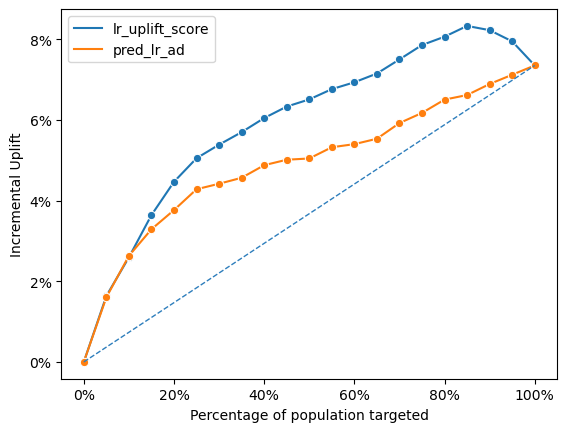

In [14]:
fig = rsm.inc_uplift_plot(
    pred_store.query("training == 0"), "converted", "yes", ["lr_uplift_score", "pred_lr_ad"], "ad", 1, qnt = 20
)

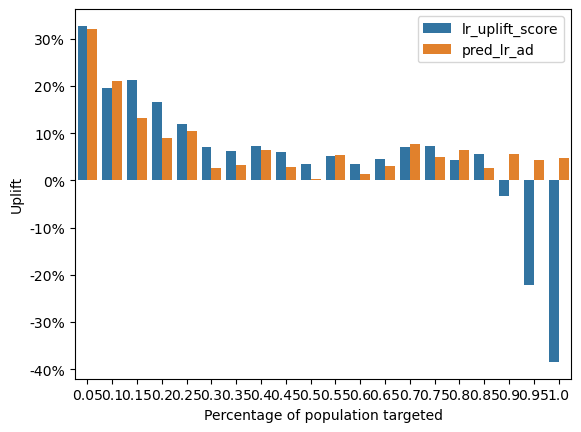

In [15]:
fig = rsm.uplift_plot(
    pred_store.query("training == 0"), "converted", "yes", ["lr_uplift_score", "pred_lr_ad"], "ad", 1, qnt = 20
)

We can probe this by examining our two predictions for each customer


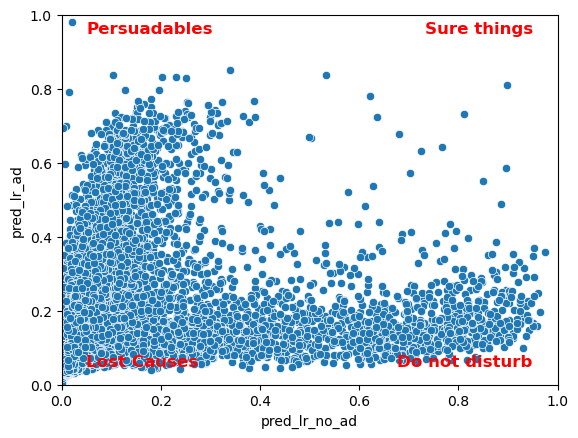

In [16]:
smp = pred_store[["pred_lr_no_ad", "pred_lr_ad"]].sample(n=30000, random_state=1234)
fig = sns.scatterplot(x = smp["pred_lr_no_ad"], y = smp["pred_lr_ad"])
fig.set(ylim=(0, 1), xlim=(0,1))
fig.text(0.05, 0.05, "Lost Causes", size="large", color='red', weight='bold')
fig.text(0.05, 0.95, "Persuadables", size='large', color='red', weight='bold')
fig.text(0.95, 0.95, "Sure things", size='large', color='red', weight='bold', horizontalalignment="right")
fig = fig.text(0.95, 0.05, "Do not disturb", size='large', color='red', weight='bold', horizontalalignment="right")


In [17]:
tab_lr_propensity = rsm.uplift_tab(
    pred_store.query("training == 0"), "converted", "yes", "pred_lr_ad", "ad", 1, qnt = 20
)

incr_profit_uplift_lr_propensity = (14.99 * tab_lr_propensity.loc[4, "incremental_resp"] - 1.5*9000*0.25) * 120000/9000
f"Incremental profit from logistic regression propensity-to-buy: ${incr_profit_uplift_lr_propensity:,.2f}"

'Incremental profit from logistic regression propensity-to-buy: $32,065.48'

In [18]:
f"We make more using uplift than propensity by ${incr_profit_uplift_lr - incr_profit_uplift_lr_propensity:,.2f}"

'We make more using uplift than propensity by $13,842.28'

7. Repeat steps 2-6 using a Random Forest model. (5 points)

For RF: 2. Train an uplift model using a Random Forest. Add the predicted scores for the treatment and control models, i.e., pred_control and pred_treatment, to cg_rct_stacked (or add them to a separate DataFrame called pred_store) and calculate the uplift score. (3 points)

In [19]:
is_num = [
    c for c in cg_rct_stacked.columns 
    if pd.api.types.is_numeric_dtype(cg_rct_stacked[c].dtype) and c not in ["ad", "training", "converted_yes"]
]
is_num

['GameLevel',
 'NumGameDays',
 'NumGameDays4Plus',
 'NumInGameMessagesSent',
 'NumSpaceHeroBadges',
 'NumFriendRequestIgnored',
 'NumFriends',
 'TimesLostSpaceship',
 'TimesKilled',
 'TimesCaptain',
 'TimesNavigator',
 'NumAdsClicked',
 'DaysUser']

In [20]:
is_not_num = [
    c for c in cg_rct_stacked.columns 
    if not pd.api.types.is_numeric_dtype(cg_rct_stacked[c].dtype) and not c == "converted"
]
is_not_num

['AcquiredSpaceship',
 'AcquiredIonWeapon',
 'PurchasedCoinPackSmall',
 'PurchasedCoinPackLarge',
 'UserConsole',
 'UserHasOldOS']

In [21]:
X = pd.concat(
    [
        cg_rct_stacked[is_num],
        pd.get_dummies(cg_rct_stacked[is_not_num], drop_first=True),
    ],
    axis=1,
)
y = cg_rct_stacked.converted_yes


Random Forest on ad == 1 with cross validation and grid search

In [22]:
clf = RandomForestClassifier()
param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_features": range(3, 5),
}
scoring = {"AUC": "roc_auc"}

clf_ad_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(
    X[(pred_store.ad == 1) & (pred_store.training == 1)],
    y[(pred_store.ad == 1) & (pred_store.training == 1)],
)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 2/5] END max_features=3, n_estimators=100; AUC: (test=0.769) total time=   1.1s
[CV 1/5] END max_features=3, n_estimators=100; AUC: (test=0.778) total time=   1.1s
[CV 4/5] END max_features=3, n_estimators=100; AUC: (test=0.775) total time=   1.1s
[CV 3/5] END max_features=3, n_estimators=100; AUC: (test=0.779) total time=   1.1s
[CV 5/5] END max_features=3, n_estimators=100; AUC: (test=0.761) total time=   1.1s
[CV 1/5] END max_features=3, n_estimators=200; AUC: (test=0.777) total time=   2.2s
[CV 2/5] END max_features=3, n_estimators=200; AUC: (test=0.775) total time=   2.2s
[CV 3/5] END max_features=3, n_estimators=200; AUC: (test=0.780) total time=   2.2s
[CV 4/5] END max_features=3, n_estimators=200; AUC: (test=0.778) total time=   2.2s
[CV 5/5] END max_features=3, n_estimators=200; AUC: (test=0.765) total time=   2.3s
[CV 1/5] END max_features=3, n_estimators=300; AUC: (test=0.780) total time=   3.4s
[CV 2/5] END ma

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END max_features=4, n_estimators=200; AUC: (test=0.782) total time=   2.9s
[CV 2/5] END max_features=4, n_estimators=200; AUC: (test=0.770) total time=   3.0s
[CV 3/5] END max_features=4, n_estimators=200; AUC: (test=0.781) total time=   3.0s
[CV 4/5] END max_features=4, n_estimators=200; AUC: (test=0.779) total time=   2.7s
[CV 5/5] END max_features=4, n_estimators=200; AUC: (test=0.761) total time=   2.8s
[CV 1/5] END max_features=4, n_estimators=300; AUC: (test=0.778) total time=   4.1s
[CV 2/5] END max_features=4, n_estimators=300; AUC: (test=0.776) total time=   4.1s
[CV 3/5] END max_features=4, n_estimators=300; AUC: (test=0.781) total time=   4.0s
[CV 4/5] END max_features=4, n_estimators=300; AUC: (test=0.779) total time=   4.1s
[CV 5/5] END max_features=4, n_estimators=300; AUC: (test=0.765) total time=   4.1s
[CV 1/5] END max_features=4, n_estimators=400; AUC: (test=0.776) total time=   5.5s
[CV 2/5] END max_features=4, n_estimators=400; AUC: (test=0.773) total time=

In [23]:
clf_ad_cv.best_params_

{'max_features': 3, 'n_estimators': 400}

In [24]:
clf_ad = RandomForestClassifier(
    n_estimators=clf_ad_cv.best_params_["n_estimators"], # 500
    max_features=clf_ad_cv.best_params_["max_features"], # 3
    oob_score=True,
    random_state=1234,
).fit(
    X[(pred_store.ad == 1) & (pred_store.training == 1)],
    y[(pred_store.ad == 1) & (pred_store.training == 1)],
)


In [25]:
# using OOB for predictions on the training data
pred_store.loc[:, "pred_rf_ad"] = clf_ad.predict_proba(X)[:, 1]
pred_store.loc[(pred_store.ad == 1) & (pred_store.training == 1), "pred_rf_ad"] = clf_ad.oob_decision_function_[:, 1]

In [26]:
clf = RandomForestClassifier()
param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_features": range(3, 5),
}
scoring = {"AUC": "roc_auc"}

clf_no_ad_cv = GridSearchCV(
    clf, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(
    X[(pred_store.ad == 0) & (pred_store.training == 1)],
    y[(pred_store.ad == 0) & (pred_store.training == 1)],
)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_features=3, n_estimators=100; AUC: (test=0.859) total time=   1.0s
[CV 2/5] END max_features=3, n_estimators=100; AUC: (test=0.864) total time=   1.0s
[CV 3/5] END max_features=3, n_estimators=100; AUC: (test=0.868) total time=   0.9s
[CV 4/5] END max_features=3, n_estimators=100; AUC: (test=0.863) total time=   0.9s
[CV 5/5] END max_features=3, n_estimators=100; AUC: (test=0.873) total time=   0.9s
[CV 1/5] END max_features=3, n_estimators=200; AUC: (test=0.864) total time=   2.0s
[CV 3/5] END max_features=3, n_estimators=200; AUC: (test=0.872) total time=   2.0s
[CV 2/5] END max_features=3, n_estimators=200; AUC: (test=0.862) total time=   2.0s
[CV 4/5] END max_features=3, n_estimators=200; AUC: (test=0.864) total time=   2.1s
[CV 5/5] END max_features=3, n_estimators=200; AUC: (test=0.871) total time=   2.1s
[CV 1/5] END max_features=3, n_estimators=300; AUC: (test=0.872) total time=   2.8s
[CV 2/5] END ma

In [27]:
clf_no_ad_cv.best_params_


{'max_features': 4, 'n_estimators': 400}

In [28]:
clf_no_ad = RandomForestClassifier(
    n_estimators=clf_no_ad_cv.best_params_["n_estimators"], # 3
    max_features=clf_no_ad_cv.best_params_["max_features"], # 500
    oob_score=True,
    random_state=1234,
).fit(
    X[(pred_store.ad == 0) & (pred_store.training == 1)],
    y[(pred_store.ad == 0) & (pred_store.training == 1)],
)

In [29]:
pred_store.loc[:, "pred_rf_no_ad"] = clf_no_ad.predict_proba(X)[:, 1]
pred_store.loc[(pred_store.ad == 0) & (pred_store.training == 1), "pred_rf_no_ad"] = clf_no_ad.oob_decision_function_[:, 1]
pred_store["rf_uplift_score"] = pred_store.pred_rf_ad - pred_store.pred_rf_no_ad

For RF 3. Calculate the Uplift (%) and Incremental Uplift (%) for the uplift model (use 20 instead of the standard 10 groups) and plot performance metrics. Interpret the plots. (3 points)

> Hint: Use functions from the pyrsm package (version 0.7.5 or newer) to generate the uplift table (uplift_tab), the incremental uplift (inc_uplift_plot), and the uplift plot (uplift_plot). 


In [30]:
tab_rf = rsm.uplift_tab(
    pred_store.query("training == 0"), "converted", "yes", "rf_uplift_score", "ad", 1, qnt = 20
)
tab_rf

,pred,bins,cum_prop,T_resp,T_n,C_resp,C_n,incremental_resp,inc_uplift,uplift
0,rf_uplift_score,1,0.05,205,448,58,583,160.430532,1.782561,0.358104
1,rf_uplift_score,2,0.10,351,890,91,1113,278.232704,3.091474,0.268053
2,rf_uplift_score,3,0.15,476,1341,121,1641,377.120658,4.190230,0.220344
3,rf_uplift_score,4,0.20,560,1790,146,2212,441.853526,4.909484,0.143300
4,rf_uplift_score,5,0.25,642,2247,173,2742,500.230853,5.558121,0.128488
5,rf_uplift_score,6,0.30,712,2689,197,3181,545.469664,6.060774,0.103701
6,rf_uplift_score,7,0.35,762,3135,218,3665,575.525239,6.394725,0.068719
7,rf_uplift_score,8,0.40,804,3557,230,4134,606.102080,6.734468,0.073940
8,rf_uplift_score,9,0.45,848,4000,241,4601,638.480330,7.094226,0.075768
9,rf_uplift_score,10,0.50,885,4480,256,5144,662.045101,7.356057,0.049459


For RF: 4. Using the incremental_resp column from the performance metric table created through the uplift_tab function, calculate the incremental profit you expect to make if you targeted the best 30,000 customers of 120,000 using the uplift model. (3 points)

> Hint: For every n-tile, the incremental_resp tells you how many incremental purchases were made when customers up to that n-tile were targeted. To extrapolate to the best 30,000 from 120,000, notice that there are a total of 9,000 customers who got the ad in cg_rct_stacked


In [31]:
incr_profit_uplift_rf = (14.99 * tab_rf.loc[4, "incremental_resp"] - 1.5*9000*0.25) * 120000/9000
f"Incremental profit from Random Forest Uplift: ${incr_profit_uplift_rf:,.2f}"

'Incremental profit from Random Forest Uplift: $54,979.47'

5. Calculate the Uplift (%) and Incremental Uplift (%) you would get if you used a propensity model (use 20 instead of the standard 10 groups). Compare the performance metrics between the uplift and propensity models and interpret the differences. (3 points)

>Hint: Use uplift and incremental uplift plots to compare the uplift and propensity models 

It is helpful to compare the multiple models on the same graph. The `inc_uplift_plot` and `uplift_plot` functions can do this:

The uplift model dominates provided we are targeting at least 15-20% of customers (that it does not dominate before we target that many suggests there are no "Sure Things" in this data). It also relegates all the "Do Not Disturbs" into the last 10-15% of targeted consumers.

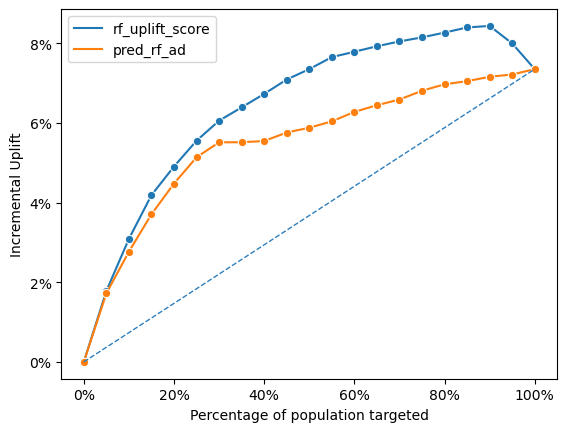

In [32]:
fig = rsm.inc_uplift_plot(
    pred_store.query("training == 0"), "converted", "yes", ["rf_uplift_score", "pred_rf_ad"], "ad", 1, qnt = 20
)

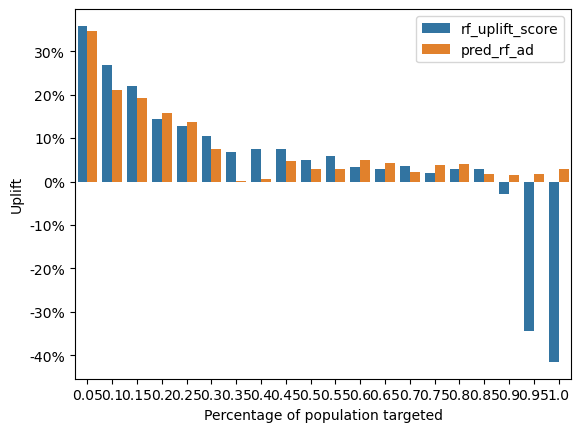

In [33]:
fig = rsm.uplift_plot(
    pred_store.query("training == 0"), "converted", "yes", ["rf_uplift_score", "pred_rf_ad"], "ad", 1, qnt = 20
)

We can probe this by examining our two predictions for each customer


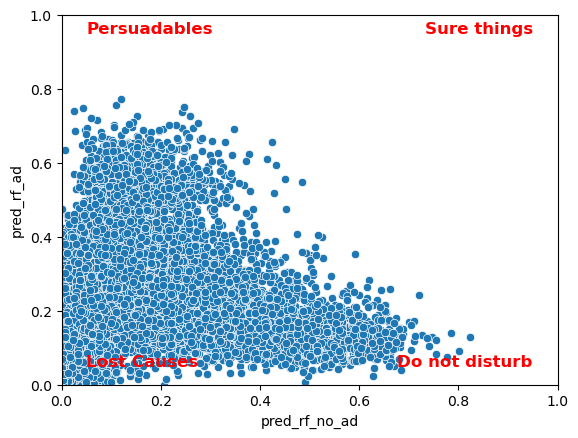

In [34]:
smp = pred_store[["pred_rf_no_ad", "pred_rf_ad"]].sample(n=30000, random_state=1234)
fig = sns.scatterplot(x = smp["pred_rf_no_ad"], y = smp["pred_rf_ad"])
fig.set(ylim=(0, 1), xlim=(0,1))
fig.text(0.05, 0.05, "Lost Causes", size="large", color='red', weight='bold')
fig.text(0.05, 0.95, "Persuadables", size='large', color='red', weight='bold')
fig.text(0.95, 0.95, "Sure things", size='large', color='red', weight='bold', horizontalalignment="right")
fig = fig.text(0.95, 0.05, "Do not disturb", size='large', color='red', weight='bold', horizontalalignment="right")


In [35]:
tab_rf_propensity = rsm.uplift_tab(
    pred_store.query("training == 0"), "converted", "yes", "pred_rf_ad", "ad", 1, qnt = 20
)

incr_profit_uplift_rf_propensity = (14.99 * tab_rf_propensity.loc[4, "incremental_resp"] - 1.5*9000*0.25) * 120000/9000
f"Incremental profit from Random Forest propensity-to-buy: ${incr_profit_uplift_rf_propensity:,.2f}"

'Incremental profit from Random Forest propensity-to-buy: $47,490.65'

In [36]:
f"We make more using uplift than propensity by ${incr_profit_uplift_rf - incr_profit_uplift_rf_propensity:,.2f}"


'We make more using uplift than propensity by $7,488.82'

## Part II: Targeting the optimal percent of customers (14 points) 

So far we have targeted 25% of model-selected customers by picking the best 30,000 out of the set of 120,000 customers. Determine if more or less than 25% of customers should be targeted. 

1. What formula would you use to select customers to target using a propensity model if your goal is to maximize profits? What percentage of customers in the ad treatment test set in cg_rct_stacked would you target based on the propensity model? (3 points)


To breakeven we need:

Pr(Buy) x Marig on Sale - Cost of Offer > 0

which is the same as  

Pr(Buy | Treatment) x Margin on Sale - Cost of Offer > 0 

for a propensity model.

In [37]:
lr_propensity_target_pct = (pred_store.loc[(pred_store.ad == 1) & (pred_store.training == 0), "pred_lr_ad"] > (1.5/14.99)).mean()
f"{100 * lr_propensity_target_pct:.2f}%"

'47.99%'

In [38]:
rf_propensity_target_pct = (pred_store.loc[(pred_store.ad == 1) & (pred_store.training == 0), "pred_rf_ad"] > (1.5/14.99)).mean()
f"{100 * rf_propensity_target_pct:.2f}%"

'50.83%'

2. What formula would you use to select customers to target using an uplift model if your goal is to maximize incremental profits? What percentage of customers in the ad treatment test set in cg_rct_stacked would you target based on the uplift model? (3 points)

Pr(Buy | Treatment) x Margin on Sale - Cost of Offer > Pr(Buy | Control) x Margin on Sale  

In [39]:
lr_uplift_target_pct = (pred_store.loc[(pred_store.ad == 1) & (pred_store.training == 0), "lr_uplift_score"] > (1.5/14.99)).mean()
f"{100 * lr_uplift_target_pct:.2f}%"

'21.93%'

In [40]:
rf_uplift_target_pct = (pred_store.loc[(pred_store.ad == 1) & (pred_store.training == 0), "rf_uplift_score"] > (1.5/14.99)).mean()
f"{100 * rf_uplift_target_pct:.2f}%"

'30.18%'

* The uplift model (Logistic Regression) suggests targeting 22% of customers.
* The uplift model (Random Forest) suggests targeting 30% of customers.

3. Rounding the targeting percentage numbers you calculated in 1. and 2. to the nearest 5%, use the uplift table you created for the propensity and uplift models in Part I to calculate the incremental profits you would have obtained in the test set in cg_rct_stacked dataset if you had targeted the optimal percentage of customers suggested by each model. (2 points)

In [41]:
# Logistic regression
target_pct = 0.50
incremental_resp = tab_lr_propensity.loc[tab_lr_propensity.cum_prop == target_pct, "incremental_resp"] 
lr_max_profit_prop = (14.99 * incremental_resp - 1.5 * 9000 * target_pct) * 120000 / 9000
f"Optimal profit from Logistic Regression Propensity-to-Buy: ${lr_max_profit_prop.values[0]:,.2f}"

'Optimal profit from Logistic Regression Propensity-to-Buy: $799.86'

In [42]:
# Logistic regression
target_pct = 0.20
incremental_resp = tab_lr.loc[tab_lr.cum_prop == target_pct, "incremental_resp"] 
lr_max_profit_uplift = (14.99 * incremental_resp - 1.5 * 9000 * target_pct) * 120000 / 9000
f"Optimal profit from Logistic Regression Uplift: ${lr_max_profit_uplift.values[0]:,.2f}"

'Optimal profit from Logistic Regression Uplift: $44,387.75'

In [43]:
# Random Forest
target_pct = 0.50
incremental_resp = tab_rf_propensity.loc[tab_rf_propensity.cum_prop == target_pct, "incremental_resp"] 
rf_max_profit_prop = (14.99 * incremental_resp - 1.5 * 9000 * target_pct) * 120000 / 9000
f"Optimal profit from Random Forest Propensity-to-Buy: ${rf_max_profit_prop.values[0]:,.2f}"

'Optimal profit from Random Forest Propensity-to-Buy: $15,838.55'

In [44]:
# Logistic regression
target_pct = 0.30
incremental_resp = tab_rf.loc[tab_rf.cum_prop == target_pct, "incremental_resp"] 
rf_max_profit_uplift = (14.99 * incremental_resp - 1.5 * 9000 * target_pct) * 120000 / 9000
f"Optimal profit from Random Forest: ${rf_max_profit_uplift.values[0]:,.2f}"

'Optimal profit from Random Forest: $55,021.20'

In [45]:
uplift_diff = rf_max_profit_uplift.values[0] - rf_max_profit_prop.values[0]
f"Improvement ($) in optimal profit from Random Forest Propensity vs Uplift: ${uplift_diff:,.2f}"

'Improvement ($) in optimal profit from Random Forest Propensity vs Uplift: $39,182.65'

In [46]:
uplift_pct = 100 * (rf_max_profit_uplift.values[0] - rf_max_profit_prop.values[0])/rf_max_profit_prop.values[0]
# uplift_pct = (rf_max_profit_uplift.values[0] / rf_max_profit_prop.values[0] - 1) * 100
f"Improvement (%) in optimal profit from Random Forest Propensity vs Uplift: {uplift_pct:,.2f}%"

'Improvement (%) in optimal profit from Random Forest Propensity vs Uplift: 247.39%'

5. Give two reasons why one model performs better than the other on incremental profit when the optimal percentage of customers is selected for each model (2 points)

In [47]:
rsm.md(f"The uplift model increases incremental profits by ${uplift_diff:,.2f}, a {uplift_pct:.2f}% increase over the propensity model. There are two reasons for this. First, the uplift model sorts consumers by uplift, not propensity, which is the right sorting order if we want to maximize incremental profits. Second, the uplift model uses a breakeven that takes into account the fact that the marginal customer can generate profit organically.")

The uplift model increases incremental profits by $39,182.65, a 247.39% increase over the propensity model. There are two reasons for this. First, the uplift model sorts consumers by uplift, not propensity, which is the right sorting order if we want to maximize incremental profits. Second, the uplift model uses a breakeven that takes into account the fact that the marginal customer can generate profit organically.